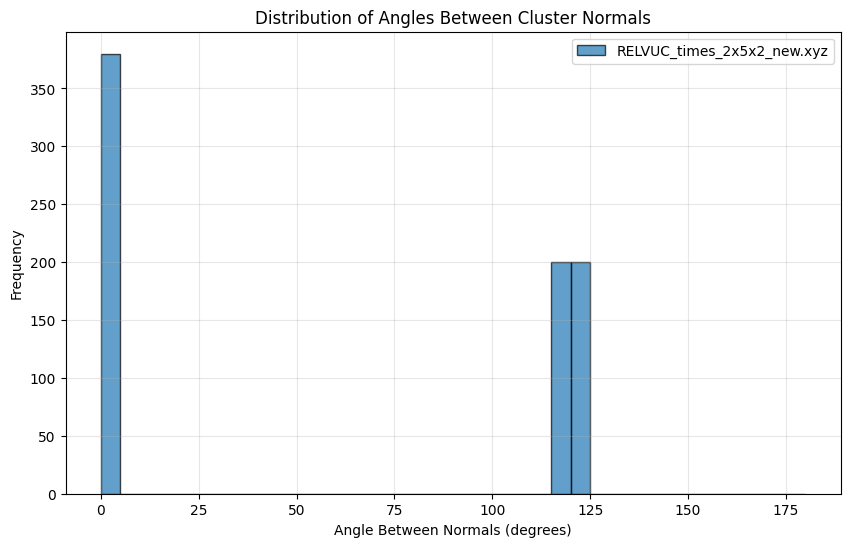

In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations

# **********************************

base_path = r'C:\Users\Builder\Desktop\temp\ustozga3'
input_file = r'RELVUC_times_2x5x2_new.xyz'
output_file = r'RELVUC_times_2x5x2_new.txt'


# **********************************

def compute_normals(df):
    """Calculate normal vectors for each cluster using PCA/SVD."""
    points = df[['x', 'y', 'z']].values
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    _, _, Vh = np.linalg.svd(centered, full_matrices=False)
    normal = Vh[2, :]
    # Ensure consistent normal orientation (optional)

    return normal * np.sign(normal[2])  # Flip if z-component is negative

def calculate_angles(normals):
    """Calculate angles between all pairs of normal vectors in degrees."""
    # Normalize vectors to ensure numerical stability
    normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]
    
    # Vectorized computation of all pairwise dot products
    dot_products = np.dot(normals, normals.T)
    
    # Clip values to avoid numerical errors in arccos
    dot_products = np.clip(dot_products, -1.0, 1.0)
    
    # Calculate angles in radians then convert to degrees
    angles = np.degrees(np.arccos(dot_products))
    
    
    # Extract unique pairwise combinations (upper triangle without diagonal)
    i, j = np.triu_indices_from(angles, k=1)
 
    return angles[i, j]

# Load and process data
columns = ['x', 'y', 'z', 'clusterid']
df = pd.read_csv(os.path.join(base_path, input_file), sep=r'\s+', skiprows=2, names=columns)

# Calculate normals for each cluster
normals = df.groupby("clusterid")[['x', 'y', 'z']].apply(compute_normals)
normals_array = np.array(normals.tolist())

# Calculate all pairwise angles
angles = calculate_angles(normals_array)
# angles = np.where(angles>90, angles-90, angles)


np.savetxt(os.path.join(base_path, output_file), angles, fmt="%s")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(angles, bins=36, range=(0, 180), edgecolor='black', alpha=0.7, label=input_file, align='mid')
plt.xlabel('Angle Between Normals (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Angles Between Cluster Normals')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()